In [1]:
# the purpose of this notebook is to test an analytical solution for my model
# for the special case where sediment supply is infinite (H >> H*)
# and attrition does not occur (beta = 0)
# a derivation (taken from the gravel river transporter tutorial) is below

$$\frac{\partial z}{\partial t} = U - \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} + \beta Q_s \right)$$

> This says that in a world with no bedrock abrasion, changes in profile elevation depend only on uplift and sediment processes (sediment divergence and attrition that degrades the bed material).
> If we assume a steady state condition $\left( \frac{\partial z}{\partial t} = 0 \right )$ and that no attrition occurs $\left(\beta = 0\right)$, then the above simplifies to:

$$U = \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x}\right)$$

> The goal is to isolate $S$, which lives within $Q_s$, so first isolate sediment transport rate:

$$\frac{\partial Q_s}{\partial x} = UB(1-\phi)$$

>integrate with respect to x:

$$Q_s = UBx(1-\phi)$$

> Replace $Q_s$ with full formulation from Wickert & Schildgen:

$$k_{Qs}IQS^{7/6} = UBx(1-\phi)$$

> And rearrange:

$$S^{7/6} = \frac{UBx(1-\phi)}{k_{Qs}IQ}$$

> If $Q=rBx$, we can further simplify:

$$S^{7/6} = \frac{U(1-\phi)}{k_{Qs}Ir}$$

> This is the formulation that we want to use for $Q$, because it's consistent with our (W&S) derivation of valley width (unlike $Q=k_hx^2$, which is completely empirical and doesn't directly tie in with our calculated valley width).

>Finally, to isolate $S$, we have:

$$S = \left(\frac{U(1-\phi)}{k_{Qs}Ir}\right)^{6/7}$$

Great! This gives us a single value for slope. Now the goal is to see if our model also produces constant slope (and if that slope is equal to the prediction made using this equation) at steady state when sediment supply is infinite and attrition is absent.

Because of the simplifications we're made, our list of parameters is substantially shorter. For example, we don't need to worry about creating arrays to hold bedrock elevation, different erodibilities, different abradabilities, etc., because no bedrock is exposed so the model is blind to those differences in bedrock.

We may also not even need arrays for sediment and a characteristic sediment thickness (commented out), because the assumption is the <i>everything</i> is sediment.

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# now set up arrays and parameters
dx = 1000 # grid spacing
x = np.arange(0, 4000, dx) # domain length

# H = 100 + np.zeros(len(x)) # sediment thickness
# z = np.linspace(1, 0.1, len(x)) # + H # need to start with slight bedrock slope
z = np.zeros(len(x))

U = 0.0005 # uplift rate
phi = 0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
kxb = 25 # valley width coeffecient
Pxb = 1/5 # valley width exponent
# Hstar = 0.1 # characteristic sediment thickness

B = kxb * (x**Pxb) # valley width 
# B = 100
# Q = B * r * x # total discharge
Q = (r * x**(6/5))/(1 + Pxb)

tau = 5
gamma = 0.5

In [21]:
# now create a function that attempts to capture this all as simply as possible
# don't need bedrock slope because that's only for calculating channel width, 
# and we're not even worrying about that as a comparison metric

def all_sed(dx, x, z, U, phi, kqs, I, r, kxb, Pxb, B, Q, tau, gamma, num_steps=55):
    
    # set timestep
    dt = (0.5 * dx * dx / (kqs*Q[-1]))
    
    # create arrays
    Qs = np.zeros(len(x))
    E = np.zeros(len(x))
    dzdt = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    E_vals = np.zeros((2, len(x))) # store current and past erosion rates in this array
    E_avg = np.zeros(len(x)) # weighted average erosion rates
    
    # set boundary conditions
    Qs[0] = 0
#     E[-1] = 0
#     dzdt[-1] = 0
    
    # track uplift
    total_dzdt = 0
    
    for i in range(num_steps):
        
        # calculate slope
        S = np.abs(np.diff(z)/dx)
        
        # calculate sediment transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        
        # calculate lateral sediment flux
#         if all(E_avg == 0): # = 0:
#             ql[:] = 0
#         else:
#             ql[:] = E_avg * gamma
        
        # erosion
        # E[:-1] = (1/((1-phi)*B[1:])) * (np.diff(Qs)/dx) # - ql[1:])
        E[1:] = (1/((1-phi)*B[1:])) * (np.diff(Qs)/dx) # - ql[1:])
        
        # calculate change in elevation
        dzdt[:-1] = U - E[1:]
        
        # update profile
        z[:] += dzdt * dt
        
        # track total change in elev so we can account for this when comparing to prediction
        total_dzdt += dzdt * dt
        
        # calculate weight for lateral sediment flux
#         wt = 1 - np.exp(-dt/tau)
        
        # add the most recent erosion rate as a new top row, and drop the bottom row
#         E_vals = np.vstack([E, E_vals])
#         E_vals = np.delete(E_vals, obj = 2, axis = 0)
        
#         # calculate average E
#         E_avg = (wt*E_vals[0]) + ((1 - wt)*E_vals[1])
        
    cum_time = num_steps * dt
    print(cum_time)
        
    return (S, Qs, ql, E, dzdt, z, total_dzdt, dt) #, wt, E_vals, E_avg, dt)

In [22]:
# now write a test
test = [dx, x, z, U, phi, kqs, I, r, kxb, Pxb, B, Q, tau, gamma]

# and run it
slope, Qs, ql, E, dzdt, model_z, total_dzdt, dt = all_sed(*test)

5409.841952911626


In [23]:
slope

array([2.15386535e-10, 2.16148788e-06, 2.65357889e-03])

In [24]:
print(Q)
print(Qs)

[     0.          33175.59754612  76217.50865455 123983.60491032]
[0.00000000e+00 7.17283630e-11 7.68039477e-06 5.01901840e-02]


In [25]:
print(Qs[1:]/Q[1:])

[2.16208202e-15 1.00769428e-10 4.04813072e-07]


In [26]:
(slope[0]**(7/6))*kqs*I

2.1620820206656817e-15

In [27]:
# Qs_test = kqs * I * Q[2] * (0.07845)**(7./6.)
# print(Qs_test)

In [28]:
# erosion_rate_expected = (48-22)/(dx * B[2])
# print(erosion_rate_expected)

In [29]:
# now solve for predicted steady state slope
# slope_pred = ((U * (1-phi))/(kqs*I*r))**(6./7.)
slope_pred = (((U * B[1:] * (1-phi)) + (U * gamma))/(kqs*I*B[1:]*r))**(6./7.)

# okay, now make a line using that constant slope
y = -slope_pred * x[1:] + 166

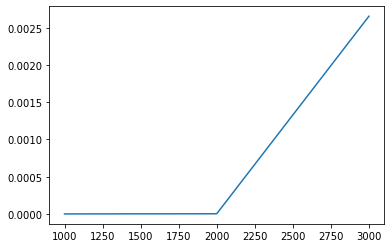

In [30]:
plt.plot(x[1:], slope)

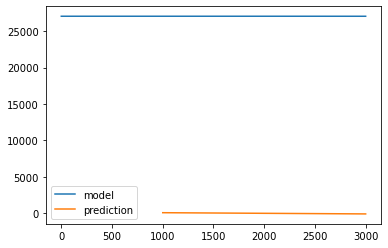

In [31]:
plt.plot(x, z, label = 'model')
plt.plot(x[1:], y, label = 'prediction')
plt.legend()

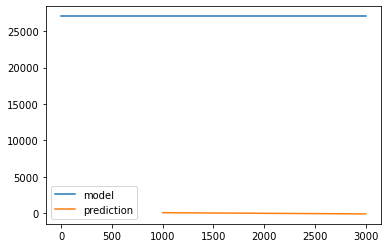

In [15]:
plt.plot(x, z, label = 'model')
plt.plot(x[1:], y, label = 'prediction')
plt.legend()

$$\frac{\partial z}{\partial t} = U - \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} + \beta Q_s - q_L\right)$$

> This says that in a world with no bedrock abrasion, changes in profile elevation depend only on uplift and sediment processes (sediment divergence and attrition that degrades the bed material, and sediment additions from lateral inputs).
> If we assume a steady state condition $\left( \frac{\partial z}{\partial t} = 0 \right )$ and that no attrition occurs $\left(\beta = 0\right)$, then the above simplifies to:

$$U = \frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} - q_L\right)$$

> At steady state, $q_L$ should just be equal to the uplift rate times some fraction ($\gamma$) of hillslope material that is delivered to the fluvial network as coarse material. In other words:

$$q_L = U\gamma$$

> This brings us to

$$\frac{\partial Q_s}{\partial x} - U\gamma = UB(1-\phi)$$

> The goal is to isolate $S$, which lives within $Q_s$, so first isolate sediment transport rate:

$$\frac{\partial Q_s}{\partial x} = UB(1-\phi) + U\gamma$$

>integrate with respect to x:

$$Q_s = UBx(1-\phi) + U\gamma x$$

> Replace $Q_s$ with full formulation from Wickert & Schildgen:

$$k_{Qs}IQS^{7/6} = UBx(1-\phi) + U\gamma x$$

> And rearrange:

$$S^{7/6} = \frac{UBx(1-\phi) + U\gamma x}{k_{Qs}IQ}$$

> If $Q=rBx$, we can further simplify:

$$S^{7/6} = \frac{UB(1-\phi) + U\gamma}{k_{Qs}IrB}$$

> This is the formulation that we want to use for $Q$, because it's consistent with our (W&S) derivation of valley width (unlike $Q=k_hx^2$, which is completely empirical and doesn't directly tie in with our calculated valley width).

>Finally, to isolate $S$, we have:

$$S = \left(\frac{UB(1-\phi) + U\gamma}{k_{Qs}IrB}\right)^{6/7}$$

Great! This gives us a single value for slope. Now the goal is to see if our model also produces constant slope (and if that slope is equal to the prediction made using this equation) at steady state when sediment supply is infinite and attrition is absent.

Because of the simplifications we're made, our list of parameters is substantially shorter. For example, we don't need to worry about creating arrays to hold bedrock elevation, different erodibilities, different abradabilities, etc., because no bedrock is exposed so the model is blind to those differences in bedrock.

We may also not even need arrays for sediment and a characteristic sediment thickness (commented out), because the assumption is the <i>everything</i> is sediment.


$$S = \left(\frac{5}{11} \frac{Ux(1-\phi)}{K_{qs}Ir}\right)^{(6/7)}$$